# Examining color selection at z~5

This notebook explores various parameters that affect optical color selection of quasars at z~5. The most prominent effect is the dependence of the selection efficiency on Lya equivalent width. Some discussion of this appears in McGreer et al. 2013,2017; in fact this notebook is used as the basis for the discussion in the appendix of McGreer et al. 2017.

First, the necessary imports from simqso to be able to generate arbitrary simulation grids and associated spectra.

In [1]:
%pylab inline
import matplotlib.gridspec as gridspec
from astropy.cosmology import WMAP9
from simqso.sqgrids import *
from simqso import sqbase
from simqso import hiforest
from simqso.sqrun import buildSpectraBySightLine,buildQsoSpectrum
from simqso import sqphoto
from simqso import sqmodels
random.seed(123)

Populating the interactive namespace from numpy and matplotlib


Set the wavelength grid to cover the optical/IR range at low resolution.

In [2]:
# cover 3000A to 5um at R=500
wave = sqbase.fixed_R_dispersion(3000,5e4,500)

Build a set of IGM absorption sightlines based on the model given in McGreer et al. 2013.

In [3]:
forestModel = sqmodels.forestModels['McGreer+2013']
forestSpec = hiforest.IGMTransmissionGrid(wave,forestModel,100,zmax=5.3)
forestVar = HIAbsorptionVar(forestSpec)

## Selection dependence on Lya EW and UV continuum slope

This first simulation utilizes a 4-d grid where the last two dimensions are Lya equivalent width and continuum shape. The grid spans the luminosity and redshift ranges of the z~5 quasar sample from CFHTLS discussed in McGreer et al. 2017. The Lya EW is a grid of 5 fixed values, and the UV continuum spectral index is a grid of 6 fixed values.

In [4]:
lyaews = [0.,15,30,60,120]
uvslopes = [-1.5,-1.0,-0.6,-0.4,-0.2,0.0]
nperbin = 100
M = AbsMagVar(UniformSampler(-28,-23),restWave=1450)
z = RedshiftVar(UniformSampler(4.65,5.35))
lya = GaussianLineEqWidthVar(FixedSampler(lyaews),'LyaEW',1215.67,5.0)
uvslope = QsoSimVar(FixedSampler(uvslopes),'uvslope')
qsoGrid = QsoSimGrid([M,z,lya,uvslope],(10,7,5,6),nperbin,fixed_vars=['LyaEW','uvslope'],
                     cosmo=WMAP9,units='luminosity')

The far-UV slope is set to -1.5 (e.g., Lusso et al. 2016) with a breakpoint at 1100 Ang.

In [5]:
contVar = BrokenPowerLawContinuumVar([ConstSampler(-1.5),
                                      FixedSampler(qsoGrid.uvslope)],[1100.])
qsoGrid.addVars([contVar,forestVar])

The spectra will be mapped to photometry that matches the characteristics of the CFHTLS Wide survey. The SDSS bandpasses are added for comparison.

In [6]:
qsoGrid.loadPhotoMap([('CFHT','CFHTLS_Wide'),('SDSS','Legacy')])

Now run the simulation and generate the spectra. This takes a while.

In [7]:
_ = buildSpectraBySightLine(wave,qsoGrid,verbose=5)

simulating  210000  quasar spectra
units are  luminosity
max number iterations:  1
processing  2170  obj in group  0


With the spectra in hand, convolve them with the survey bandpasses to get simulated photometry. Add photometric noise to get realistic photometry.

In [8]:
photoData = sqphoto.calcObsPhot(qsoGrid.synFlux,qsoGrid.photoMap)
qsoGrid.addData(photoData)

Now plot the "observed" photometry in r-i/i-z color space, which is the main selection cut. One panel is shown for each of the fixed Lya EW values. Note how decreasing the EW drives the colors away from the selection cuts (shown as black lines, solid line is "weak" criteria from McGreer et al. 2017, dashed line is "strict" criteria). The points are downsampled by a factor of 10 for clarity, and color-coded by the UV spectral index.

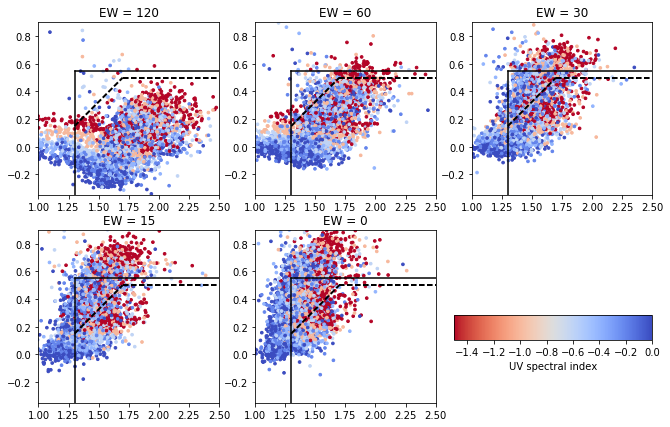

In [9]:
g_mags = qsoGrid.asGrid('obsMag') # last axis is ugriz
g_clrs = -diff(g_mags,axis=-1) # last axis is u-g,g-r,r-i,i-z
g_z = qsoGrid.asGrid('z')
g_a = qsoGrid.asGrid('uvslope')
fig = figure(figsize=(11,7))
for ew_i in range(5):
    ax = subplot(2,3,ew_i+1)
    pts = scatter(g_clrs[:,:,4-ew_i,:,::10,2],g_clrs[:,:,4-ew_i,:,::10,3],
                  c=g_a[:,:,4-ew_i,:,::10],s=7,cmap='coolwarm_r')
    ax.set_title('EW = %d' % qsoGrid.gridCenters[2][4-ew_i])
    ax.plot([1.3,1.3],[-0.5,0.55],c='k')
    ax.plot([1.3,2.5],[0.55,0.55],c='k')
    ri = linspace(1.3,1.7,2)
    ax.plot(ri,polyval([0.875,0.15],ri-1.3),c='k',ls='--',lw=2)
    ax.plot([1.7,2.5],[0.5,0.5],c='k',ls='--',lw=2)
    ax.set_xlim(1.0,2.5)
    ax.set_ylim(-0.35,0.9)
cbax = fig.add_axes([0.65,0.25,0.25,0.05])
cb = fig.colorbar(pts,cax=cbax,orientation='horizontal')
_ = cb.ax.set_xlabel('UV spectral index')

For comparison, here are the simulated colors (no noise added) in the SDSS bands. This is to show that with SDSS colors the effect is even more severe, and it is more difficult to select low-EW quasars.

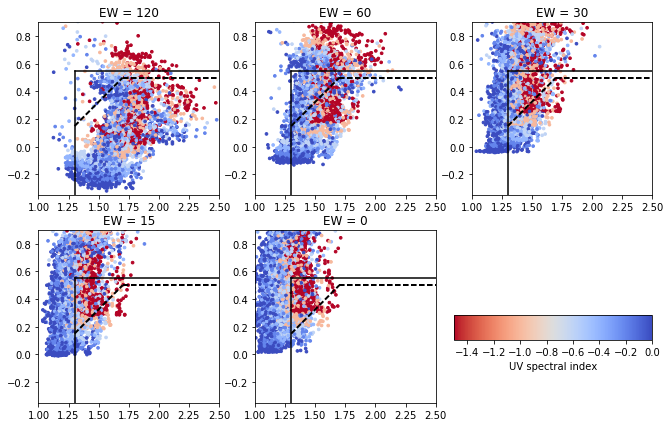

In [10]:
g_mags = qsoGrid.asGrid('synMag') # last axis is ugriz
g_clrs = -diff(g_mags,axis=-1) # last axis is u-g,g-r,r-i,i-z
fig = figure(figsize=(11,7))
for ew_i in range(5):
    ax = subplot(2,3,ew_i+1)
    pts = scatter(g_clrs[:,:,4-ew_i,:,::10,2+5],g_clrs[:,:,4-ew_i,:,::10,3+5],
                  c=g_a[:,:,4-ew_i,:,::10],s=7,cmap='coolwarm_r')
    ax.set_title('EW = %d' % qsoGrid.gridCenters[2][4-ew_i])
    ax.plot([1.3,1.3],[-0.5,0.55],c='k')
    ax.plot([1.3,2.5],[0.55,0.55],c='k')
    ri = linspace(1.3,1.7,2)
    ax.plot(ri,polyval([0.875,0.15],ri-1.3),c='k',ls='--',lw=2)
    ax.plot([1.7,2.5],[0.5,0.5],c='k',ls='--',lw=2)
    ax.set_xlim(1.0,2.5)
    ax.set_ylim(-0.35,0.9)
cbax = fig.add_axes([0.65,0.25,0.25,0.05])
cb = fig.colorbar(pts,cax=cbax,orientation='horizontal')
_ = cb.ax.set_xlabel('UV spectral index')

Calculate the selection efficiency by applying the color criteria and determining the fraction of quasars passing those criteria within each grid cell.

In [11]:
mags = qsoGrid.asGrid('obsMag')
fluxes = qsoGrid.asGrid('obsFlux')
ferrs = qsoGrid.asGrid('obsFluxErr')
snr_u = fluxes[...,0]/ferrs[...,0]
snr_g = fluxes[...,1]/ferrs[...,1]
g_minus_r = mags[...,1] - mags[...,2]
r_minus_i = mags[...,2] - mags[...,3]
i_minus_z = mags[...,3] - mags[...,4]
# "weak" criteria from McGreer+17
weak_color_sel = ( (snr_u < 2.2) &
                   ( (g_minus_r > 1.8) | (snr_g < 2.2) ) &
                   (r_minus_i>1.3) & 
                   ( (i_minus_z > -0.5) & (i_minus_z<0.55) ) )
# "strict" criteria
strict_color_sel = ( weak_color_sel & 
                     (i_minus_z < 0.15 + 0.875*(r_minus_i-1.3)) &
                     (i_minus_z < 0.5) )

Display the efficiency by plotting absolute mag vs. redshift, split into panels corresponding to each of the fixed Lya EW and UV spectral index values. The color coding is the selected fraction.

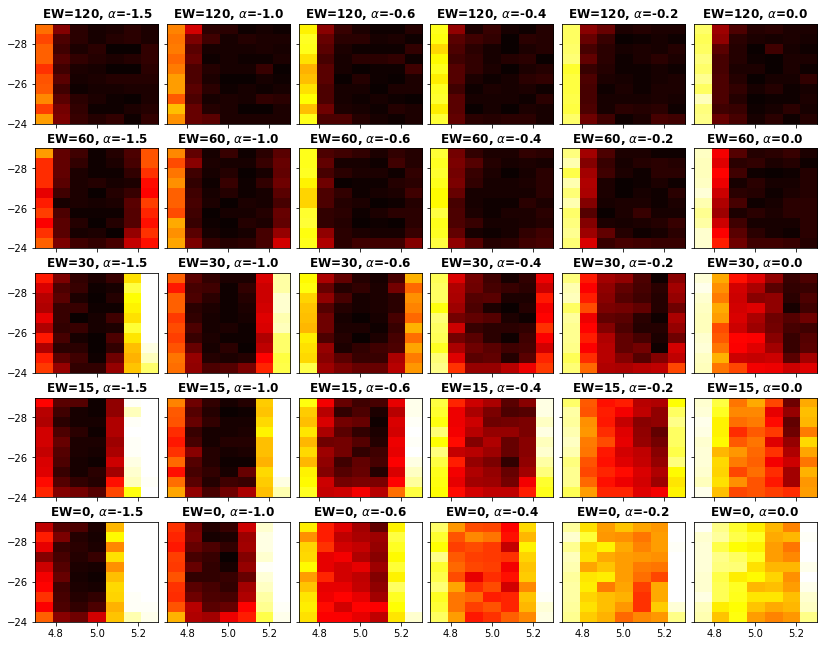

In [12]:
gs = gridspec.GridSpec(5,6)
gs.update(wspace=0.07,hspace=0.25)
figure(figsize=(14,11))
for i in range(5):
    for j in range(6):
        ax = plt.subplot(gs[i,j])
        if j>0: ax.yaxis.set_ticklabels([])
        if i<4: ax.xaxis.set_ticklabels([])
        fsel = weak_color_sel[:,:,-(i+1),j].sum(axis=-1) / float(nperbin)
        imshow(fsel,vmin=0,vmax=1,extent=[4.7,5.3,-24,-29],
               interpolation='nearest',aspect='auto',cmap=cm.hot_r)
        title(r'EW=%d, $\alpha$=%.1f' %
              (qsoGrid.gridCenters[2][-(i+1)],qsoGrid.gridCenters[3][j]),
              size=12,weight='bold')

A line plot showing the variation of the efficiency with Lya EW at the nominal UV slope.

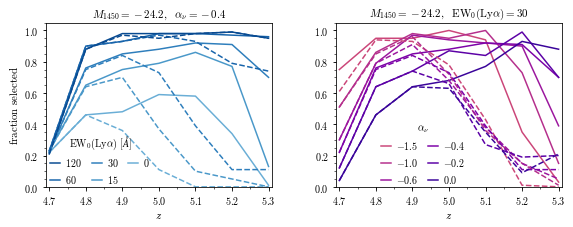

In [57]:
from matplotlib import ticker
import matplotlib
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
M_i = 7
fig = figure(figsize=(7.8,3.0))
fig.subplots_adjust(0.07,0.14,0.99,0.90,0.28)
ax1 = subplot(121)
for color_sel,ls in zip([weak_color_sel,strict_color_sel],['-','--']):
    fsel = color_sel[M_i,:,:,3].sum(axis=-1) / float(nperbin)
    for i,lyaew in enumerate(lyaews):
        lbl = '$%d$'%lyaew if ls=='-' else '_nolegend_'
        ax1.plot(qsoGrid.gridCenters[1],fsel[:,i],lw=1.5,ls=ls,
                 color=cm.Blues(0.5+float(i)/len(lyaews)/2),
                 label=lbl)
handles, labels = ax1.get_legend_handles_labels()
legend(handles[::-1],labels[::-1],
       handlelength=1,handletextpad=0.5,
       borderpad=0,columnspacing=1,
       loc=(0.02,0.01),
       ncol=3,title=r'${\rm EW}_0({\rm Ly}\alpha)\ [\AA]$',
       fontsize=10,frameon=False)#,bbox_to_anchor=(1,0.5))
ax1.set_title(r'$M_{1450}=%.1f,\ \ \alpha_\nu=%.1f$' % 
              (qsoGrid.gridCenters[0][M_i],uvslopes[3]),size=11)
# now by slope
ax2 = subplot(122)
for color_sel,ls in zip([weak_color_sel,strict_color_sel],['-','--']):
    fsel = color_sel[M_i,:,2].sum(axis=-1) / float(nperbin)
    for i,a_uv in enumerate(uvslopes):
        lbl = r'$%.1f$'%a_uv if ls=='-' else '_nolegend_'
        ax2.plot(qsoGrid.gridCenters[1],fsel[:,i],lw=1.5,ls=ls,
                 color=cm.plasma_r(0.5+float(i)/len(uvslopes)/2),
                 label=lbl)
legend(ncol=2,title=r'$\alpha_\nu$',
       handlelength=1,handletextpad=0.5,
       borderpad=0,columnspacing=1,
       loc=(0.2,0.01),
       fontsize=10,frameon=False)
ax2.set_title(r'$M_{1450}=%.1f,\ \ {\rm EW}_0({\rm Ly}\alpha)=%d$' % 
              (qsoGrid.gridCenters[0][M_i],lyaews[2]),size=11)
#
ax1.set_ylabel('$\mathrm{fraction\ selected}$',size=11)
for ax in [ax1,ax2]:
    ax.set_xlabel('$z$',size=11)
    ax.set_xlim(4.69,5.31)
    ax.set_ylim(0,1.05)
    for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(10)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%.1f$'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%.1f$'))
savefig('lya_uvslope_sel.pdf')

## Selection dependence on Lya EW and dust extinction

This simulation utilizes a 4-d grid where the last two dimensions are Lya equivalent width and dust extinction.

In [4]:
M = AbsMagVar(UniformSampler(-29,-24),restWave=1450)
z = RedshiftVar(UniformSampler(4.7,5.3))
lya = GaussianLineEqWidthVar(FixedSampler([0.,15,60,120]),'LyaEW',1215.67,10.)
dust = SMCDustVar(UniformSampler(0,0.2))
qsoGrid = QsoSimGrid([M,z,lya,dust],(10,5,4,5),50,fixed_vars=['LyaEW','smcDustEBV'],
                     cosmo=WMAP9,units='luminosity')

In this case the full quasar model is turned on, including all emission lines and iron pseudo-continuum. This roughly follows what was used in Ross et al. 2013 for the "expdust" model.

In [5]:
# the "expdust" continuum model from Ross+13
contVar = BrokenPowerLawContinuumVar([GaussianSampler(-0.5,0.2),
                                      GaussianSampler(-0.3,0.2)],
                                     [1100.])
# generate lines using the Baldwin Effect emission line model from BOSS DR9
emLineVar = generateBEffEmissionLines(qsoGrid.absMag,ExcludeLines=['LyAn','LyAb'])
# the default iron template from Vestergaard & Wilkes 2001 was modified to fit BOSS spectra
fescales = [(0,1540,0.5),(1540,1680,2.0),(1680,1868,1.6),(1868,2140,1.0),(2140,3500,1.0)]
feVar = FeTemplateVar(VW01FeTemplateGrid(qsoGrid.z,wave,scales=fescales))
# Now add the features to the QSO grid
qsoGrid.addVars([contVar,emLineVar,feVar,forestVar])

using Fe scales:  [(0, 1540, 0.5), (1540, 1680, 2.0), (1680, 1868, 1.6), (1868, 2140, 1.0), (2140, 3500, 1.0)]


In [6]:
qsoGrid.loadPhotoMap([('SDSS','Legacy'),('UKIRT','UKIDSS_LAS')])

In [7]:
# ready to generate spectra
_ = buildSpectraBySightLine(wave,qsoGrid,verbose=5)

simulating  50000  quasar spectra
units are  luminosity
max number iterations:  1
processing  490  obj in group  0


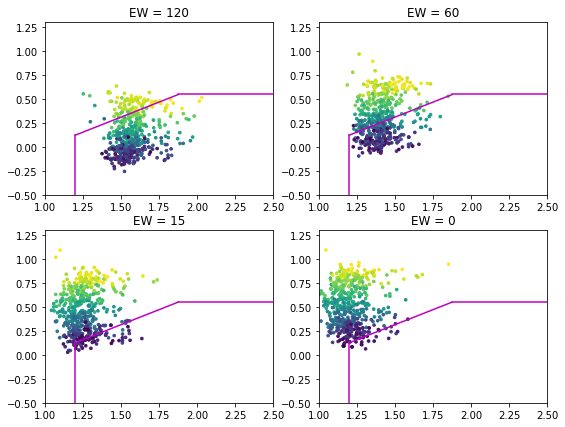

In [8]:
g_mags = qsoGrid.asGrid('synMag')
g_z = qsoGrid.asGrid('z')
figure(figsize=(9,7))
for ew_i in range(4):
    ax = subplot(2,2,ew_i+1)
    scatter(g_mags[:,:,3-ew_i,0,::5,2]-g_mags[:,:,3-ew_i,0,::5,3],
            g_mags[:,:,3-ew_i,0,::5,3]-g_mags[:,:,3-ew_i,0,::5,4],
           c=g_z[:,:,3-ew_i,0,::5],s=7)
    ax.set_title('EW = %d' % qsoGrid.gridCenters[2][3-ew_i])
    ax.plot([1.2,1.2],[-0.5,0.13],c='m')
    ax.plot([1.875,2.5],[0.55,0.55],c='m')
    ri = linspace(1.2,1.875,2)
    ax.plot(ri,polyval([0.625,0],ri-1),c='m')
    ax.set_xlim(1.0,2.5)
    ax.set_ylim(-0.5,1.3)

In [9]:
photoData = sqphoto.calcObsPhot(qsoGrid.synFlux,qsoGrid.photoMap)
qsoGrid.addData(photoData)

In [10]:
#g_mags = qsoGrid.asGrid('obsMag')
g_mags = qsoGrid.asGrid('synMag')
r_minus_i = g_mags[...,2] - g_mags[...,3]
i_minus_z = g_mags[...,3] - g_mags[...,4]
color_sel = ( (r_minus_i>1.2) & 
              (i_minus_z < 0.625*(r_minus_i-1)) &
              (i_minus_z<0.55)
            )

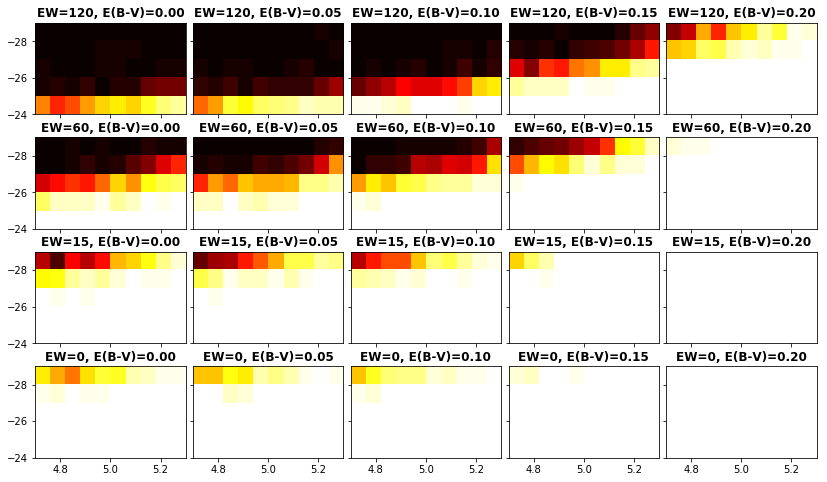

In [11]:
gs = gridspec.GridSpec(4,5)
gs.update(wspace=0.05,hspace=0.25)
figure(figsize=(14,8))
for i in range(4):
    for j in range(5):
        ax = plt.subplot(gs[i,j])
        if j>0: ax.yaxis.set_ticklabels([])
        if i<3: ax.xaxis.set_ticklabels([])
        fsel = color_sel[:,:,-(i+1),j].sum(axis=-1) / 50.
        imshow(fsel.T,vmin=0,vmax=1,extent=[4.7,5.3,-24,-29],
               interpolation='nearest',aspect='auto',cmap=cm.hot_r)
        title('EW=%d, E(B-V)=%.2f' %
              (qsoGrid.gridCenters[2][-(i+1)],qsoGrid.gridCenters[3][j]),
              size=12,weight='bold')

[750 850 950]


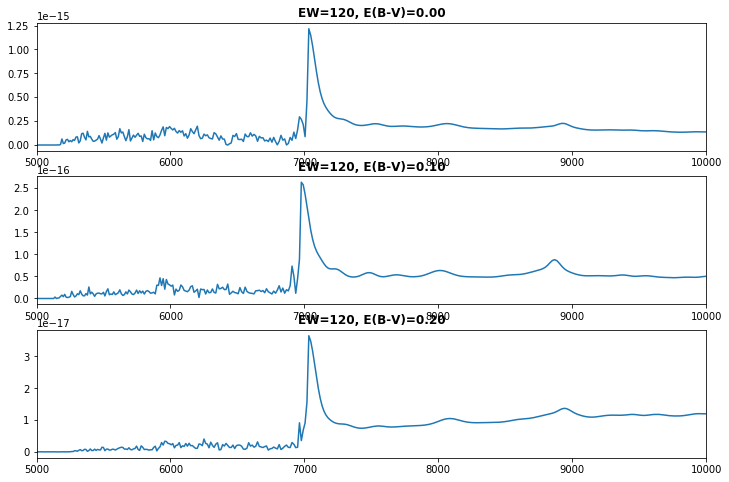

In [12]:
specFeatures = qsoGrid.getVars(SpectralFeatureVar)
ii = np.array([np.ravel_multi_index(t,qsoGrid.gridShape)
               for t in [(0,0,3,0,0),(0,0,3,2,0),(0,0,3,4,0)]])
print ii
figure(figsize=(12,8))
for _i,i in enumerate(ii):
    subplot(3,1,_i+1)
    obj = qsoGrid.data[i]
    sp = buildQsoSpectrum(wave,qsoGrid.cosmo,specFeatures,obj)
    plot(wave,sp.f_lambda)
    title('EW=%d, E(B-V)=%.2f' %
              (obj['LyaEW'],obj['smcDustEBV']),size=12,weight='bold')
    xlim(5000,1e4)